In [1]:
import cdsapi
import numpy as np
import os 
c = cdsapi.Client()

area = [46.4, -122.4, 46, -122]
years = [str(ii) for ii in 1993 + np.arange(30)]
days = [str(ii) for ii in np.arange(31) + 1]
months = [str(ii) for ii in np.arange(12) + 1]

outfolder = '../climate data/larger_area'

# Snow depth water-equivalent

In [2]:

for year in years:
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'snow_depth_water_equivalent',
            'year': year,
            'area': area,
            'time': '15:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'snow_depth_{year}.grib'))

2023-10-24 16:09:09,920 INFO Welcome to the CDS
2023-10-24 16:09:09,921 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-10-24 16:09:10,249 INFO Request is queued


KeyboardInterrupt: 

# Precipitation

In [ ]:
for year in years:
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'total_precipitation',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'precip_{year}.grib'))



## Snowfall

In [ ]:
for year in years:
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'snowfall',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'snowfall_{year}.grib'))



## Snowmelt

In [ ]:
for year in years:
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'snowmelt',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'snowmelt{year}.grib'))



# Recombine & downsample

In [2]:
from datetime import date, datetime, timedelta
import os
from typing import Tuple
import locale
from copy import deepcopy

import matplotlib
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
import numpy as np
from obspy.core.inventory.inventory import read_inventory
from obspy.core.inventory.station import Station
import pygrib
import pandas as pd

def plot_clim_at_stat(
    data: np.ndarray, latv:np.ndarray, lonv:np.ndarray, stat: Station,
    dt: timedelta, dt2: timedelta,
    startdate: datetime, ylabel: str, title: str,
        tlim: Tuple[datetime, datetime], return_data=False):
    """
    Plots the dataset from the provided *grib* for the coordinates of the
    station. The dataset is assumed to span a time window.

    :param gribfile: *.grib* file containing climate data
    :type gribfile: str
    :param stat: Seismic Station
    :type stat: Station
    :param dt: Sampling interval
    :type dt: timedelta
    :param startdate: Time of first sample
    :type startdate: datetime
    :param ylabel: Ylabel
    :type ylabel: str
    :param title: Title for plot
    :type title: str
    :param tlim: time limits that define the x-axis limits
    :type tlim: Tuple[datetime, datetime]
    """
    
    # get coords
    slat = stat.latitude
    slon = stat.longitude
    idata = deepcopy(data)
    ilatv = deepcopy(latv)
    ilonv = deepcopy(lonv)
    return plot_clim_at_coords(
        idata, ilatv, ilonv, slat, slon, dt, dt2, startdate, ylabel,
        title, tlim, return_data)


def open_grib(gribfile: str):
    grbs = pygrib.open(gribfile)
    # This should be a time series on axis 0
    grb = grbs.select()
    data = np.array([g.values for g in grb])
    # Latitude and longitude grid
    lat, lon = grb[0].latlons()
    # make those vectors
    latv = lat[:, 0]
    lonv = lon[0, :]
    if np.all(lonv>180):
        lonv -= 360
    return data, latv, lonv


def plot_clim_at_coords(
    data: np.ndarray, latv: np.ndarray, lonv: np.ndarray, slat: float,
    slon: float, dt: timedelta, dt2: timedelta, startdate: datetime,
    ylabel: str = None, title: str = None,
        tlim: Tuple[datetime, datetime] = None, return_data=False):
    """
    Finds `slat` and `slon` in the grid plots a simple 2d line plot
    as a function of time.

    :param data: a 3D array with data for the following grid
        [time, lat, lon]
    :type data: np.ndarray
    :param latv: vector containing the latitudes of grid
    :type latv: np.ndarray
    :param lonv: vector containing the longitudes of grid
    :type lonv: np.ndarray
    :param slat: Latitude of the Station
    :type slat: float
    :param slon: Longitude of the Station
    :type slon: float
    :param dt: Sampling Interval
    :type dt: timedelta
    :param startdate: Time of first sample
    :type startdate: datetime
    :param ylabel: Ylabel, defaults to None
    :type ylabel: str, optional
    :param title: Title for plot, defaults to None
    :type title: str, optional
    :param tlim: time limits that define the x-axis limits
    :type tlim: Tuple[datetime, datetime]
    """
    set_mpl_params()
    ii = np.where(np.isclose(latv, round(slat, 1)))
    jj = np.where(np.isclose(lonv, round(slon, 1)))
    datav = np.squeeze(data[:, ii, jj])
    # Downsampling
    if dt2 is not None and dt2 > dt:
        decim = int(round(dt2/dt))
        datav = np.array(
            [datav[ii:ii+decim].sum() for ii in range(len(datav)//decim)])
        dt = dt2
    # Build time vector
    t = np.array([startdate + dt*i for i in range(len(datav))])
    # plt.plot(t, datav)
    if 'temperature' in ylabel.lower():
        # Go from Kelvin to celsius
        datav -= 273.15
    if return_data:
        return t, datav
    plt.bar(t, datav)
    ax = plt.gca()
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.xlabel('(dd/mm)')
    locale.setlocale(locale.LC_ALL, "en_GB.utf8")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %h'))
    plt.xticks(rotation='vertical')
    if tlim is not None:
        ax.set_xlim(tlim)
        # set ylim according to xlim
        visible_y = datav[np.where(np.logical_and(t > tlim[0], t < tlim[1]))]
        ax.set_ylim(np.min(visible_y), np.max(visible_y))


def set_mpl_params():
    params = {
        #'font.family': 'Avenir Next',
        'pdf.fonttype': 42,
        'font.weight': 'bold',
        'figure.dpi': 150,
        'figure.figsize': (12, 9),
        'figure.facecolor': 'None',
        'axes.labelweight': 'bold',
        'axes.linewidth': 1.5,
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'axes.titleweight': 'bold',
        'xtick.labelsize': 13,
        'xtick.direction': 'in',
        'xtick.top': True,  # draw label on the top
        'xtick.bottom': True,  # draw label on the bottom
        'xtick.minor.visible': True,
        'xtick.major.top': True,  # draw x axis top major ticks
        'xtick.major.bottom': True,  # draw x axis bottom major ticks
        'xtick.minor.top': True,  # draw x axis top minor ticks
        'xtick.minor.bottom': True,  # draw x axis bottom minor ticks
        'ytick.labelsize': 13,
        'ytick.direction': 'in',
        'ytick.left': True,  # draw label on the top
        'ytick.right': True,  # draw label on the bottom
        'ytick.minor.visible': True,
        'ytick.major.left': True,  # draw x axis top major ticks
        'ytick.major.right': True,  # draw x axis bottom major ticks
        'ytick.minor.left': True,  # draw x axis top minor ticks
        'ytick.minor.right': True,  # draw x axis bottom minor ticks
        'legend.fancybox': False,
        'legend.frameon': False,
        'legend.loc': 'upper left',
        'legend.numpoints': 2,
        'legend.fontsize': 'large',
        'legend.framealpha': 1,
        'legend.scatterpoints': 3,
        'legend.edgecolor': 'inherit',
    }
    matplotlib.rcParams.update(params)
    # matplotlib.font_manager._rebuild()
set_mpl_params()

## Snow

In [3]:
snows = []
for year in years:
    snow, latv, lonv = open_grib(f'../climate data/larger_area/snow_depth_{year}.grib')
    snows.append(snow)
snow = np.vstack(snows)

In [4]:
# time vector
t = np.array([datetime(int(years[0]), 1, 1) + i*timedelta(days=1) for i in range(snow.shape[0])])


## Precipitation

In [5]:
precips = []
for year in years:
    precip, latv, lonv = open_grib(f'../climate data/larger_area/precip_{year}.grib')
    precips.append(precip)
precip = np.vstack(precips)

print('This should be something between 1 and 2:', precip[:,3,3].sum(axis=0)/30)


This should be something between 1 and 2: 1.4407162843087815


## Snowfall

In [6]:
snowfalls = []
for year in years:
    snowfall, latv, lonv = open_grib(f'../climate data/larger_area/snowfall_{year}.grib')
    snowfalls.append(snowfall)
snowfall = np.vstack(snowfalls)

print('This should be something well below 1:', snowfall[:,3,3].sum(axis=0)/30)


This should be something well below 1: 0.33723470143352946


## Snowmelt

In [7]:
snowmelts = []
for year in years:
    snowmelt, latv, lonv = open_grib(f'../climate data/larger_area/snowmelt{year}.grib')
    snowmelts.append(snowmelt)
snowmelt = np.vstack(snowmelts)

print('I guess about the same as snowfall?:', snowmelt[:,3,3].sum(axis=0)/30)
# Seems like there is a fair bit of evaporation


I guess about the same as snowfall?: 0.20322557430093488


## sanity check

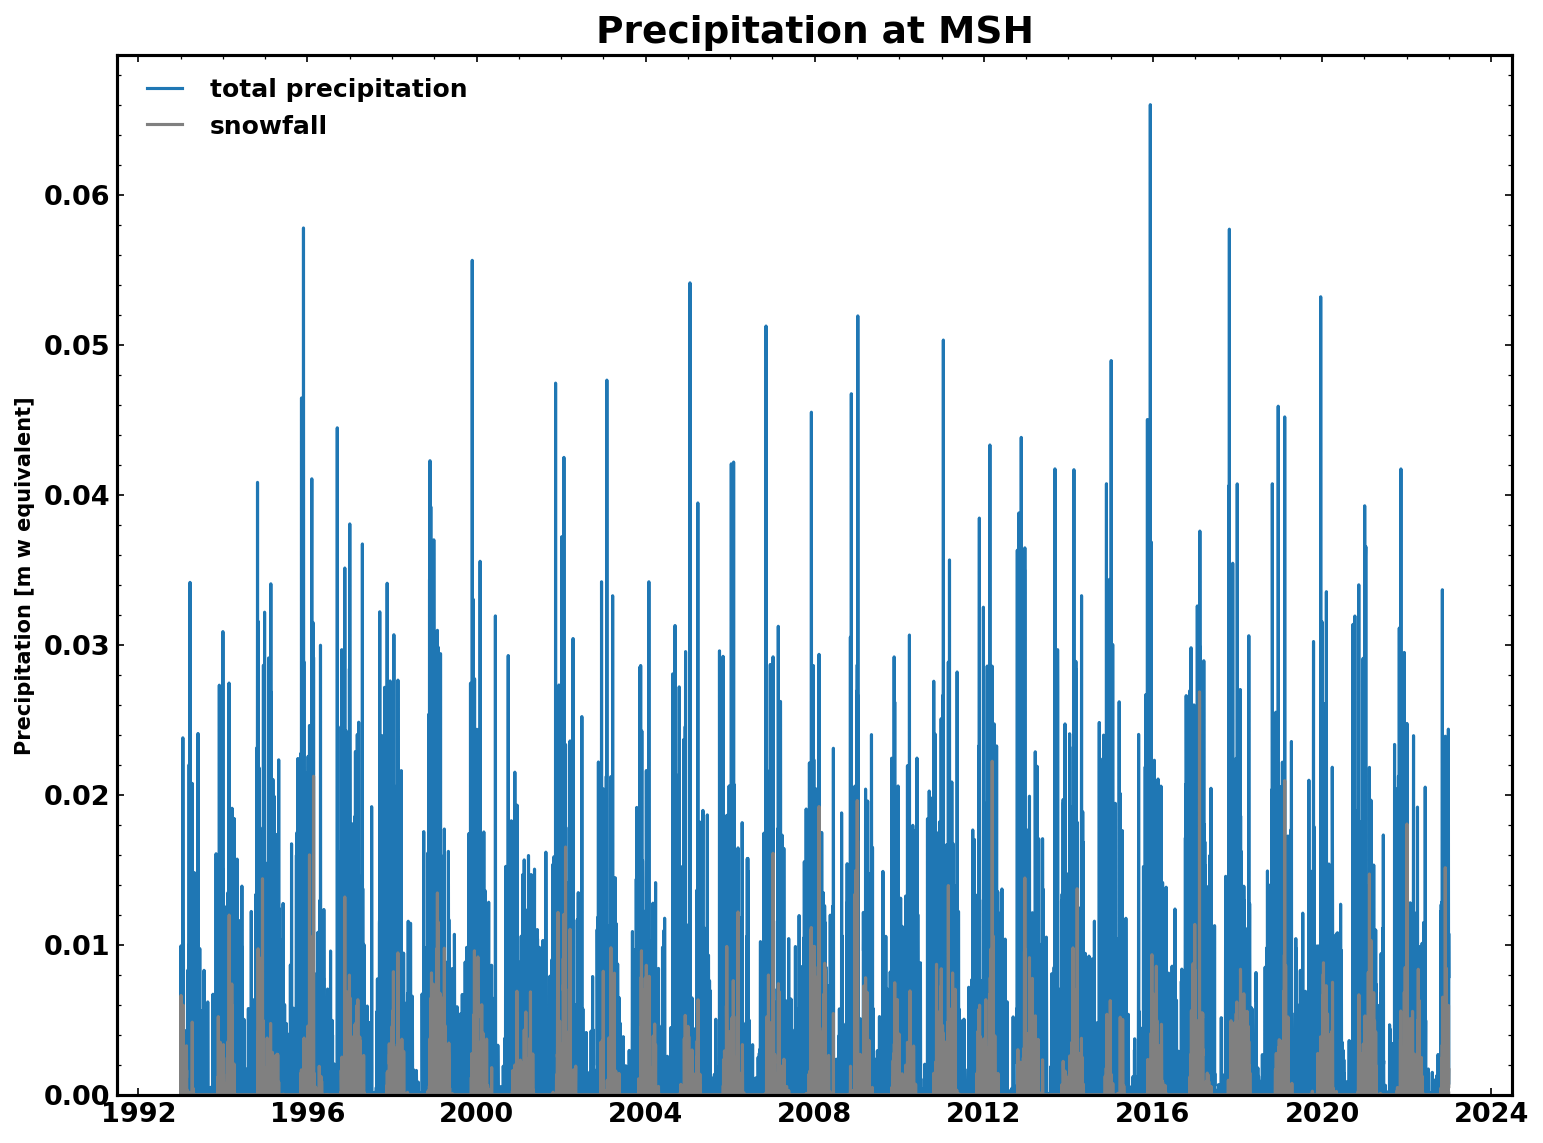

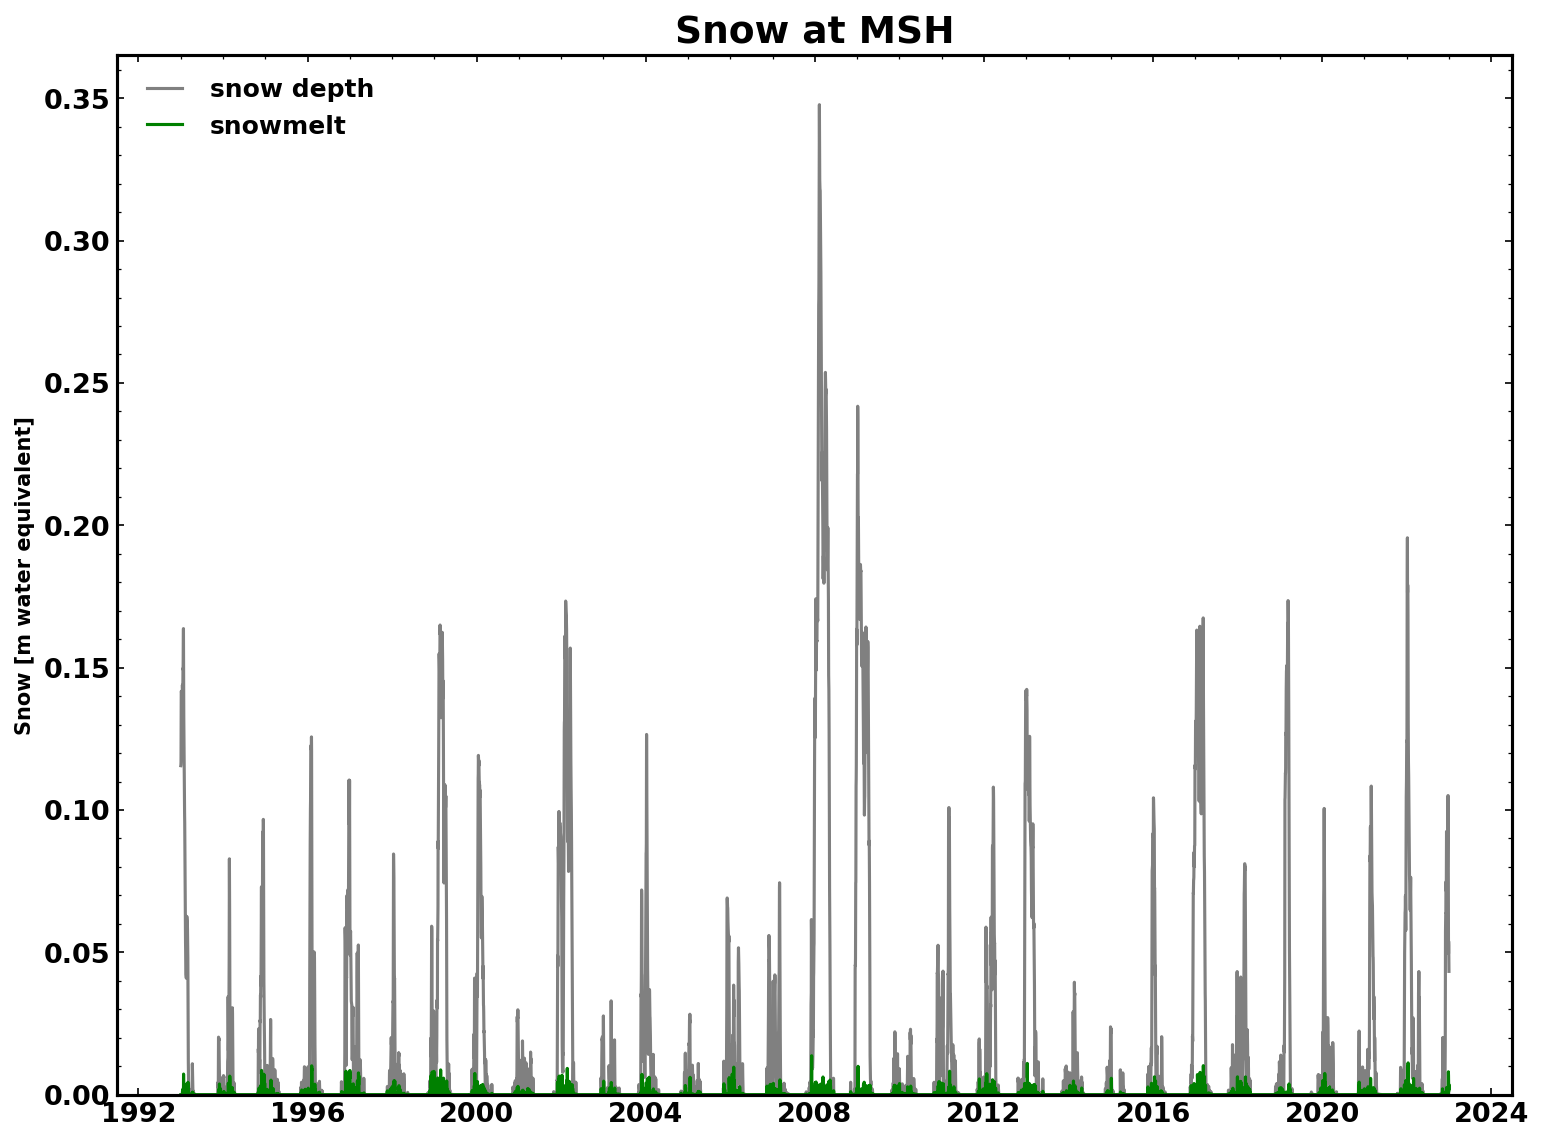

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(t, precip[:, 0, 0], label='total precipitation')
plt.plot(t, snowfall[:, 0, 0], color='grey', label='snowfall')
plt.title('Precipitation at MSH')
plt.ylabel('Precipitation [m w equivalent]')
plt.ylim((0, None))
plt.legend()

plt.figure(figsize=(12, 9))
plt.plot(t, snow[:, 0, 0], color='grey', label='snow depth')
plt.title('Snow at MSH')
plt.ylabel('Snow [m water equivalent]')
plt.plot(t, snowmelt[:, 0, 0], color='green', label='snowmelt')
plt.ylim((0, None))
plt.legend()


## safe as csv
This gets too large. NOt a good idea

In [9]:
# import pandas as pd
# snowl, precipl, snowfalll, snowmeltl, latl, lonl, datel \
#     = [], [], [], [], [], [], []
# for ii, datum in enumerate(t):
#     for jj, lat in enumerate(latv):
#         for kk, lon in enumerate(lonv):
#             snowl.append(snow[ii, jj, kk])
#             precipl.append(precip[ii, jj, kk])
#             snowmeltl.append(snowmelt[ii, jj, kk])
#             snowfalll.append(snowfall[ii, jj, kk])
#             latl.append(lat)
#             lonl.append(lon)
#             datel.append(datum)
# d = {
#     'snow depth': snowl, 'total precipitation': precipl, 'snowmelt': snowmeltl,
#     'snowfall': snowfalll, 'date': datel, 'latitude': latl, 'longitude': lonl}

# df = pd.DataFrame(data=d)
# df.to_csv(os.path.join(outfolder, 'climate_MSH.csv'))

# Do some plots and checks

In [10]:
# plot the total yearly precipitation and see whether there is a trend
snow_year = np.empty((len(years),))
precip_year = np.empty_like(snow_year)

for ii, year in enumerate(years):
    mask = np.array([int(year) == tt.year for tt in t])
    snow_year[ii] = np.mean(snow[mask, :,  :])
    precip_year[ii] = np.mean(precip[mask, :, : ].sum(axis=0))

(0.0, 1934.3729136706363)

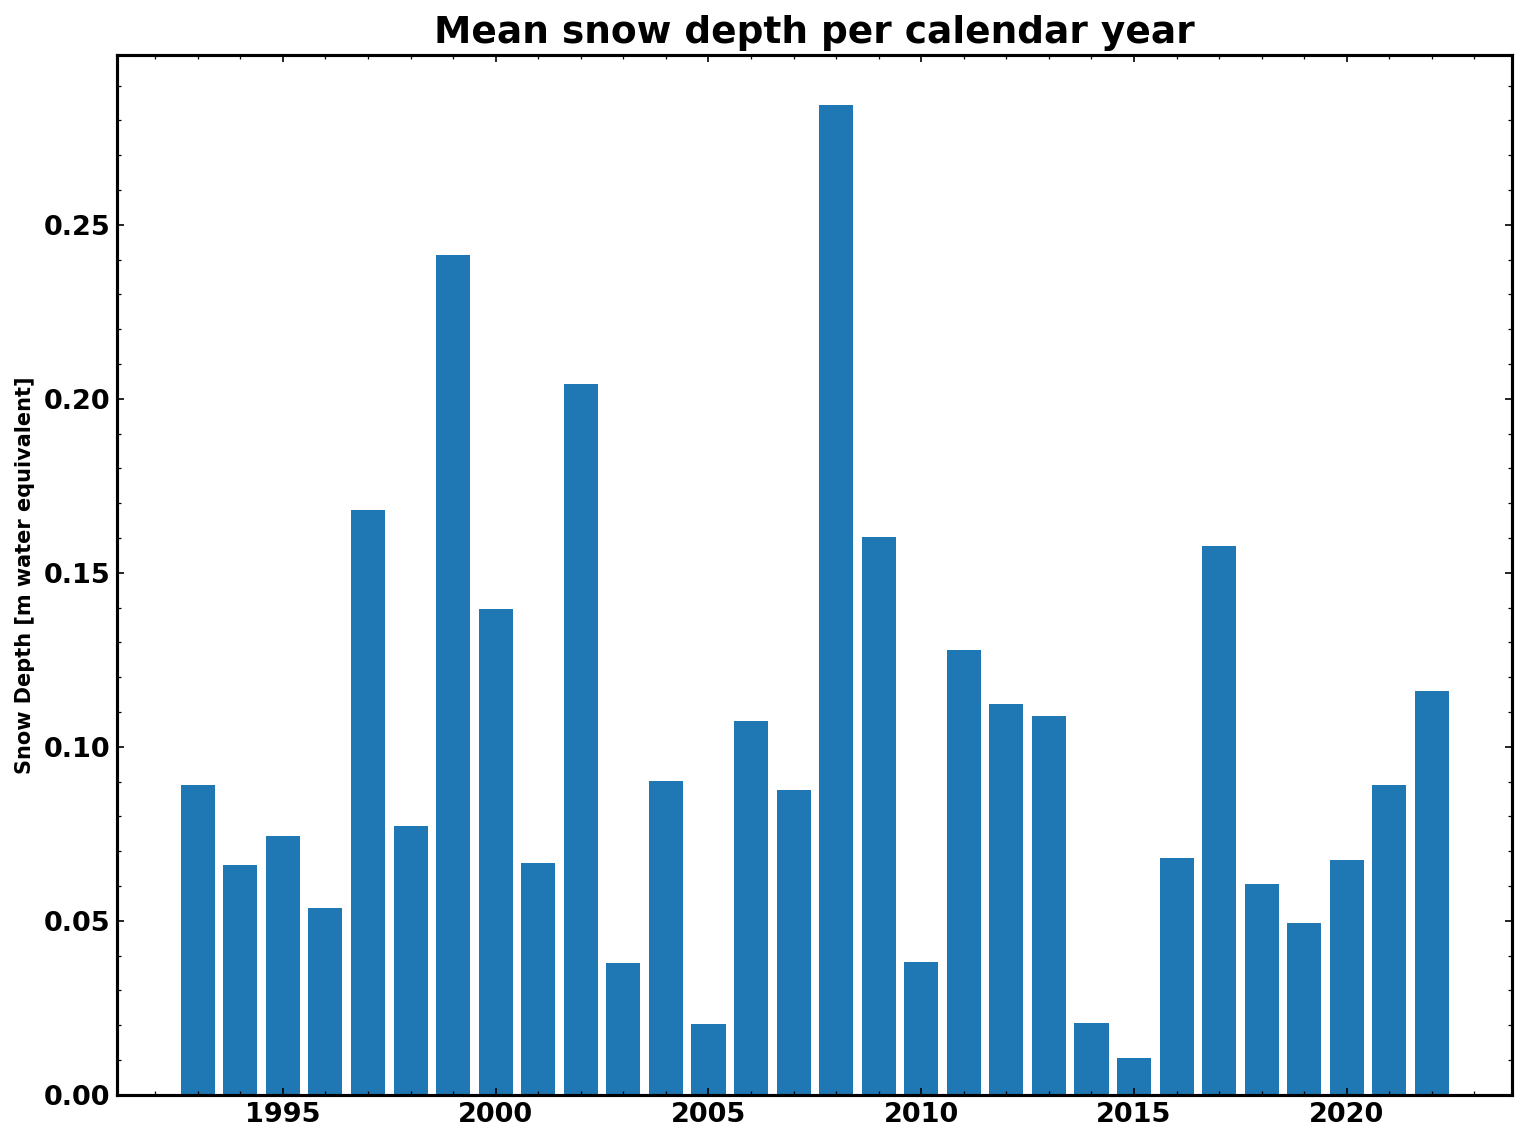

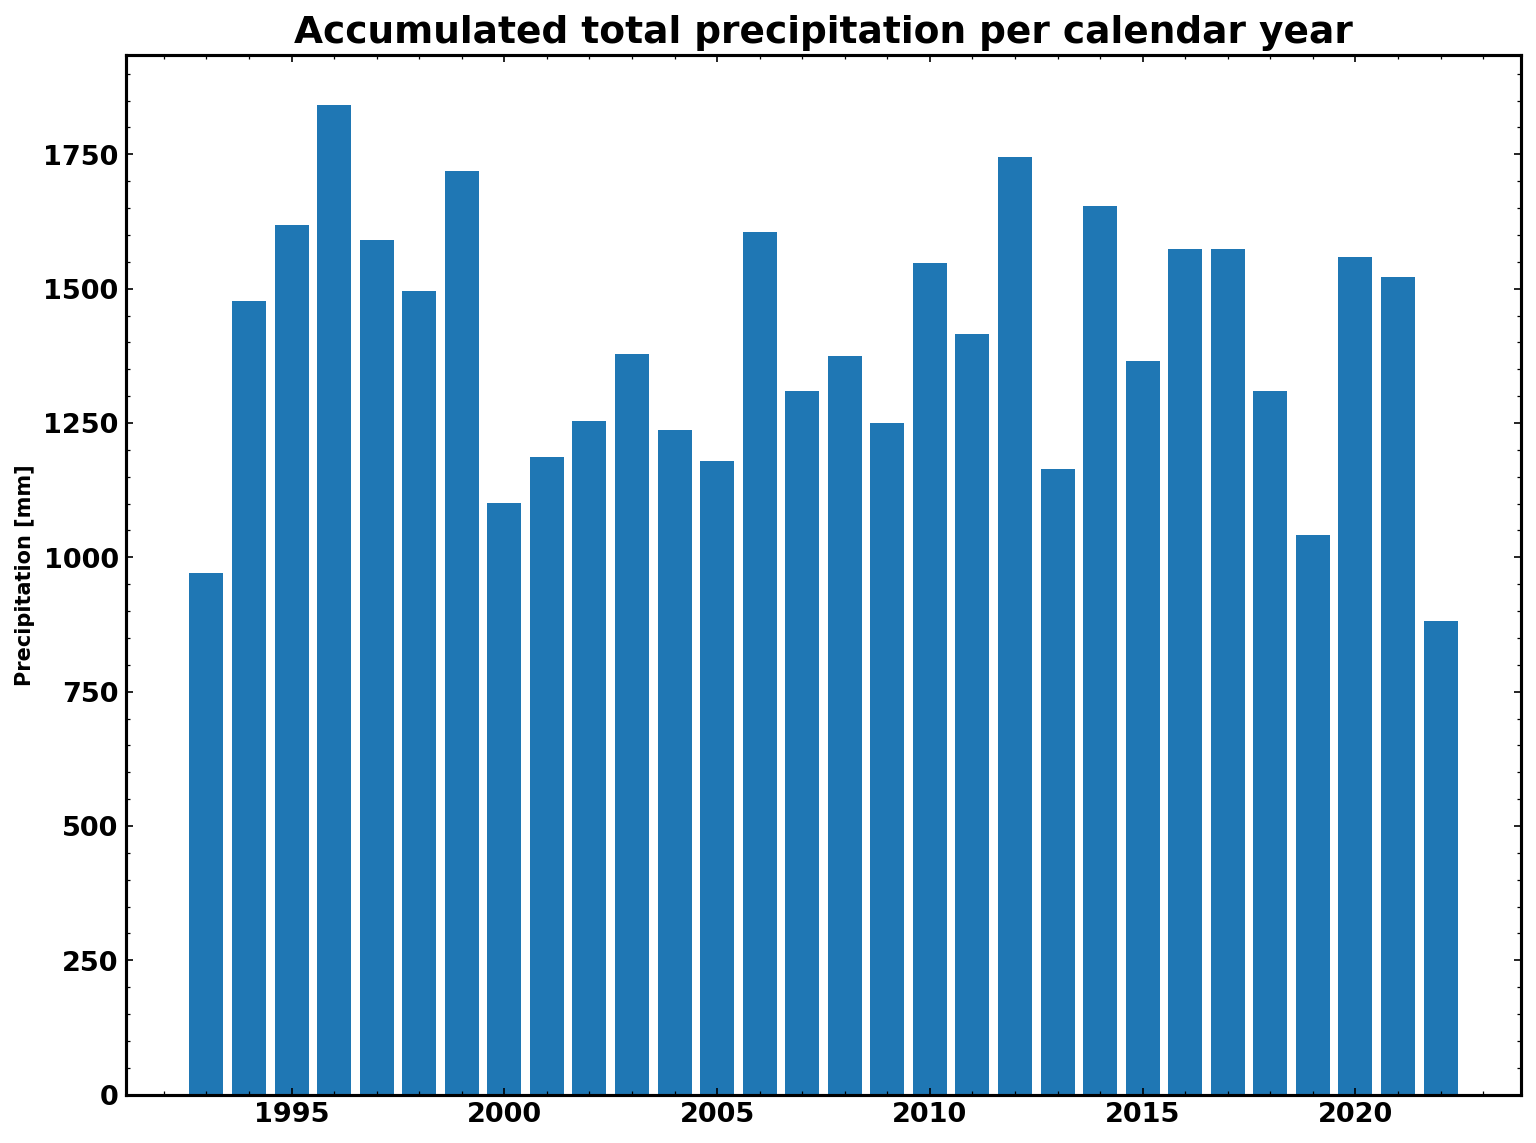

In [11]:
years_n = np.array([int(y) for y in years])

plt.figure()
plt.title('Mean snow depth per calendar year')
plt.ylabel('Snow Depth [m water equivalent]')
plt.bar(years_n, snow_year)
plt.ylim((0, None))

plt.figure()
plt.bar(years_n, precip_year*1000)
plt.title('Accumulated total precipitation per calendar year')
plt.ylabel('Precipitation [mm]')
plt.ylim((0, None))

Slope of snow accumulation  0.09981652955235777
Slope of precipitation  1398.0879446108643


(0.0, 44039.77025524223)

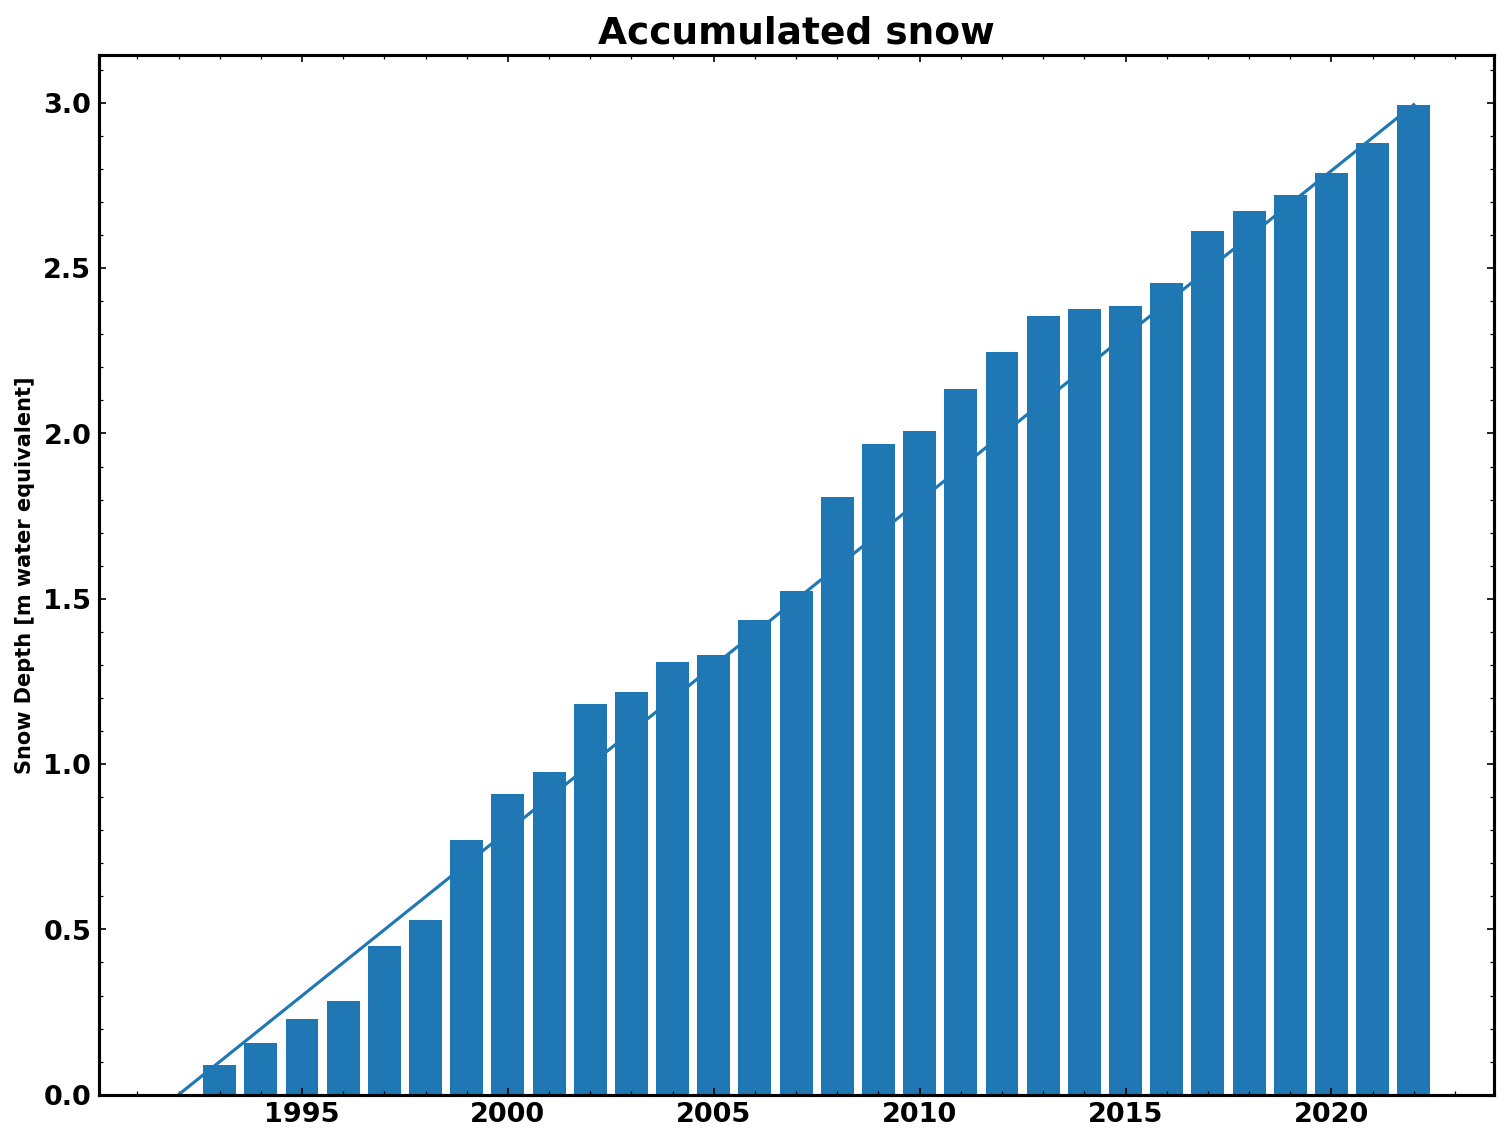

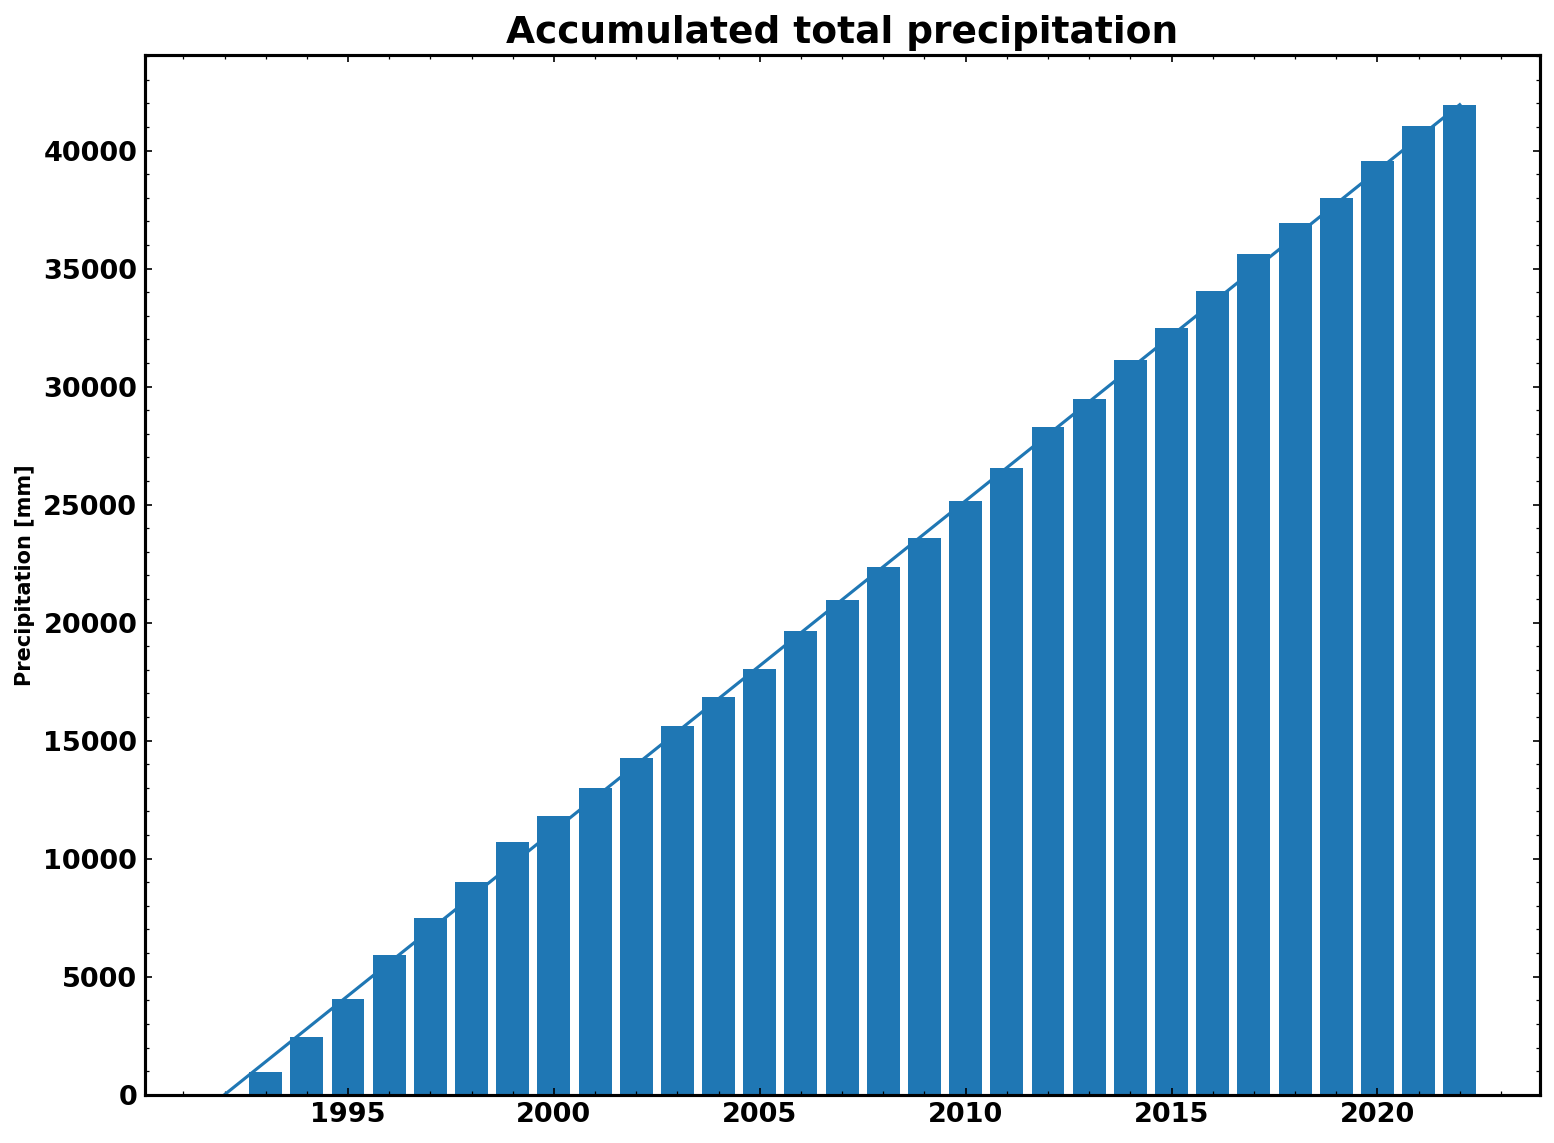

In [12]:
from scipy.stats import linregress

cum_years = np.hstack((1992, years_n))
cum_snow = np.hstack((0, np.cumsum(snow_year)))
cum_precip = np.hstack((0, np.cumsum(precip_year)))*1000

snow_slope = np.mean(np.diff(cum_snow))
print('Slope of snow accumulation ', snow_slope)
precip_slope = np.mean(np.diff(cum_precip))
print('Slope of precipitation ', precip_slope)


plt.figure()
plt.title('Accumulated snow')
plt.ylabel('Snow Depth [m water equivalent]')
plt.bar(cum_years, cum_snow)
plt.plot(cum_years, (cum_years-1992)*snow_slope)
plt.ylim((0, None))

plt.figure()
plt.bar(cum_years, cum_precip)
plt.plot(cum_years, (cum_years-1992)*precip_slope)
plt.title('Accumulated total precipitation')
plt.ylabel('Precipitation [mm]')
plt.ylim((0, None))

# Check spatial distribution of annual / and subannual values

In [13]:
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt



region = [min(lonv), max(lonv), min(latv), max(latv)]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region)
# topo is returned as lines are latitude and columns longitude


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


In [14]:
total_precip = precip.sum(axis=0)
# latv = np.unique(latl)
# lonv = np.unique(lonl)

In [15]:
from scipy.interpolate import RegularGridInterpolator

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data

# latq = np.linspace(min(topo.coords['lat'].data), max(topo.coords['lat'].data), 20)
# lonq = np.linspace(min(topo.coords['lon'].data), max(topo.coords['lon'].data), 20)


lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])

f = RegularGridInterpolator((latv, lonv), total_precip, bounds_error=False, method='linear')

precip_totalint = f(qcoords)
precip_totalint = precip_totalint.reshape(latqg.shape)

precip_total_grid = DataArray(data=precip_totalint*1000, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='P [mm]')
# precip_total_grid = DataArray(data=total_precip*1000, coords={'lon': lonv, 'lat': latv}, dims=('lat', 'lon'), name='P [mm]')


In [ ]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
pygmt.makecpt(
    cmap="batlow",
    series=f"{total_precip.min()*1000+.01}/{total_precip.max()*1000-.01}",
    continuous=True,
    reverse=False,
)

persp = [160, 30] #40
proj = "M30c"

cb_tick_increment = round(
    (total_precip.max() - total_precip.min())*1000/7,
    int(-np.floor(np.log10(1000*(total_precip.max() - total_precip.min()))) + 1))

surftype = 'sm'
with pygmt.config(
    MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
    # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
    # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
    # MAP_TICK_LENGTH_PRIMARY=0.5,
    # MAP_TICK_LENGTH_SECONDARY=0.5,
    # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
    # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
    FONT='25p,Helvetica-Bold'):
    fig.grdview(
        grid=topo,
        drapegrid=precip_total_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame=["xa", "ya", "WSnE"],
        # surftype='sm',#m0.01p',
        surftype=surftype,
        # cmap='rainbow',
        # plane="2000+gblack",
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        # Sets the height of the three-dimensional relief centimeters
        zsize="4c",
        # meshpen="0,150",
        # meshpen="1p,black",
        # contourpen="0p,black",
        # transparency=20,
        interpolation='n'
    )
    fig.colorbar(frame=[f'a{cb_tick_increment}', "x+lP", "y+l[mm]"],perspective=persp, projection=proj)
    # fig.plot(
        # x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, perspective=persp, projection=proj)
os.makedirs('../climate data/figs', exist_ok=True)
# fig.show()
fig.savefig(f'../climate data/figs/map_total_precip.png', dpi=300, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


: 

## do the same for snow

In [16]:
from scipy.interpolate import RegularGridInterpolator

total_snow = snowfall.sum(axis=0)


lonqg, latqg = np.meshgrid(lonq, latq)

f = RegularGridInterpolator((latv, lonv), total_snow, bounds_error=False, method='linear')

snow_totalint = f(qcoords)
snow_totalint = snow_totalint.reshape(latqg.shape)

snow_total_grid = DataArray(data=snow_totalint, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='snow [m]')


In [17]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
pygmt.makecpt(
    cmap="batlow",
    series=f"{total_snow.min()+.01}/{total_snow.max()-.01}",
    continuous=True,
    reverse=False,
)

persp = [160, 30] #40
proj = "M30c"

cb_tick_increment = round(
    (total_snow.max() - total_snow.min())/7,
    int(-np.floor(np.log10(total_snow.max() - total_snow.min())) + 1))

surftype = 'sm'
with pygmt.config(
    MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
    # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
    # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
    # MAP_TICK_LENGTH_PRIMARY=0.5,
    # MAP_TICK_LENGTH_SECONDARY=0.5,
    # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
    # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
    FONT='25p,Helvetica-Bold'):
    fig.grdview(
        grid=topo,
        drapegrid=snow_total_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame=["xa", "ya", "WSnE"],
        # surftype='sm',#m0.01p',
        surftype=surftype,
        # cmap='rainbow',
        # plane="2000+gblack",
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        # Sets the height of the three-dimensional relief centimeters
        zsize="4c",
        # meshpen="0,150",
        # meshpen="1p,black",
        # contourpen="0p,black",
        # transparency=20,
        interpolation='n'
    )
    fig.colorbar(frame=[f'a{cb_tick_increment}', "x+lsnow", "y+l[m]"],perspective=persp, projection=proj)
    # fig.plot(
        # x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, perspective=persp, projection=proj)
os.makedirs('../climate data/figs', exist_ok=True)
# fig.show()
fig.savefig(f'../climate data/figs/map_total_snow.png', dpi=300, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


## once more for melt

In [18]:
from scipy.interpolate import RegularGridInterpolator

total_snow = snowmelt.sum(axis=0)


lonqg, latqg = np.meshgrid(lonq, latq)

f = RegularGridInterpolator((latv, lonv), total_snow, bounds_error=False, method='linear')

snow_totalint = f(qcoords)
snow_totalint = snow_totalint.reshape(latqg.shape)

snow_total_grid = DataArray(data=snow_totalint, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='snow [m]')


In [19]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
pygmt.makecpt(
    cmap="batlow",
    series=f"{total_snow.min()+.01}/{total_snow.max()-.01}",
    continuous=True,
    reverse=False,
)

persp = [160, 30] #40
proj = "M30c"

cb_tick_increment = round(
    (total_snow.max() - total_snow.min())/7,
    int(-np.floor(np.log10(total_snow.max() - total_snow.min())) + 1))

surftype = 'sm'
with pygmt.config(
    MAP_FRAME_TYPE='fancy+', FORMAT_GEO_MAP='ddd.xx',
    # MAP_GRID_CROSS_SIZE_PRIMARY=0.20,
    # MAP_GRID_CROSS_SIZE_SECONDARY=0.20,
    # MAP_TICK_LENGTH_PRIMARY=0.5,
    # MAP_TICK_LENGTH_SECONDARY=0.5,
    # FONT_ANNOT_PRIMARY='18p,Helvetica-Bold',
    # FONT_ANNOT_SECONDARY='18p,Helvetica-Bold',
    FONT='25p,Helvetica-Bold'):
    fig.grdview(
        grid=topo,
        drapegrid=snow_total_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame=["xa", "ya", "WSnE"],
        # surftype='sm',#m0.01p',
        surftype=surftype,
        # cmap='rainbow',
        # plane="2000+gblack",
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        # Sets the height of the three-dimensional relief centimeters
        zsize="4c",
        # meshpen="0,150",
        # meshpen="1p,black",
        # contourpen="0p,black",
        # transparency=20,
        interpolation='n'
    )
    fig.colorbar(frame=[f'a{cb_tick_increment}', "x+lsnow", "y+l[m]"],perspective=persp, projection=proj)
    # fig.plot(
        # x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, perspective=persp, projection=proj)
os.makedirs('../climate data/figs', exist_ok=True)
# fig.show()
fig.savefig(f'../climate data/figs/map_total_melt.png', dpi=300, transparent=True)

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
